# MEMO
- 準備、進行中、異常発生、掃除中ごとに比較
  - クラスタリングの割合
  - 行動の特徴

- 異常検知アルゴリズムを試してみる

In [1]:
%cd /raid6/home/yokoyama/har-for-or/
import os
from glob import glob
import pickle
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from tqdm import tqdm

from src.data import load_dataset_iterable
from src.model import SQVAE
from src.utils import video, yaml_handler, vis

/raid6/home/yokoyama/har-for-or


/raid6/home/yokoyama/har-for-or/.venv/lib/python3.10/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


In [2]:
dataset_num = 3
model_type = "sqvae"

if dataset_num == 3:
    v = 0
    preparing = [(1, 0), (5, 7199)]
    intraoperative = [(5, 7200), (17, 18919)]
    emergency = [(), ()]
    cleaning = [(17, 18920), (19, -1)]
elif dataset_num == 4:
    v = 1
    preparing = [(1, 0), ()]
    intraoperative = [(4, 0), ()]
    emergency = [(), ()]
    cleaning = [(15, 0), ()]
elif dataset_num == 5:
    v = 2
    preparing = [(1, 0), ()]
    intraoperative = [(4, 0), ()]
    emergency = [(), ()]
    cleaning = [(15, 0), ()]
checkpoint_dir = f"models/individual/{model_type}/version_{v}"

# load classes
path = f"../datasets/dataset{dataset_num:02d}/annotation/classes.txt"
classes = np.loadtxt(path, str, usecols=0, delimiter=",")
classes = [c.title() for c in classes]

# load annotation
path = glob(f"../datasets/dataset{dataset_num:02d}/annotation/*test*.txt")[0]
video_num = int(os.path.basename(path).split(".")[0].split("_")[2])
annotations = np.loadtxt(path, str, skiprows=1, delimiter=" ")

# load config
config = yaml_handler.load(f"{checkpoint_dir}/individual-{model_type}.yaml")
seq_len = config.seq_len
stride = config.stride
if config.mask_leg:
    n_pts = 13 + 2
else:
    n_pts = 17 + 2

In [3]:
data_dirs = glob(f"../datasets/dataset{dataset_num:02d}/train/*/") + glob(
    f"../datasets/dataset{dataset_num:02d}/test/*/"
)
data_dirs = sorted(data_dirs, key=lambda x: int(os.path.basename(os.path.dirname(x))))

label_counts_all = {}
results_all = {}
for data_dir in tqdm(data_dirs):
    video_num = os.path.basename(os.path.dirname(data_dir))

    # load preds
    results = []
    paths = glob(os.path.join(data_dir, f"pred_{model_type}", "*"))
    for path in paths:
        with open(path, "rb") as f:
            results.append(pickle.load(f))

    label_counts = {i: {} for i in range(config.n_clusters)}
    max_n_frame = 0
    for result in results:
        key = result["key"]
        n_frame = int(key.split("_")[1])
        if max_n_frame < n_frame:
            max_n_frame = n_frame

        # label count
        label_pred = int(result["label"])
        if n_frame not in label_counts[label_pred]:
            label_counts[label_pred][n_frame] = 0
        label_counts[label_pred][n_frame] += 1

    vals_dict = {}
    for label, count_dict in label_counts.items():
        if len(count_dict) < 2:
            continue
        n_frames = np.array(list(count_dict.keys()))
        counts = np.array(list(count_dict.values()))

        idxs = n_frames // stride
        n_samples = max_n_frame // stride + 1
        vals = np.zeros((n_samples,), np.float32)
        vals[idxs] = counts

        vals_dict[label] = vals

    labels = list(vals_dict.keys())
    vals = np.array(list(vals_dict.values())).T

    label_counts_all[video_num] = vals
    results_all[video_num] = results

100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


In [4]:
def moving_average(vals, size):
    b = np.ones(size) / size
    vals_mean = np.full_like(vals, np.nan)
    vals_mean[size - 1 :] = np.convolve(vals, b, mode="valid")

    return vals_mean

In [5]:
# label_ratio_all = {}
# for video_num, vals in label_counts_all.items():
#     for i in range(vals.shape[1]):
#         vals.T[i] = moving_average(vals.T[i].copy(), 10)

#     # compute ratio
#     sums = vals.sum(axis=1, keepdims=True)
#     sums[sums == 0] = 1
#     vals /= sums

#     label_ratio_all[video_num] = vals

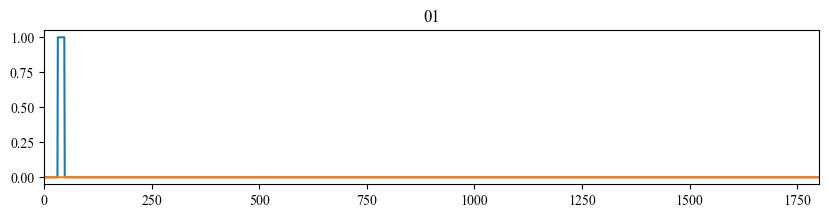

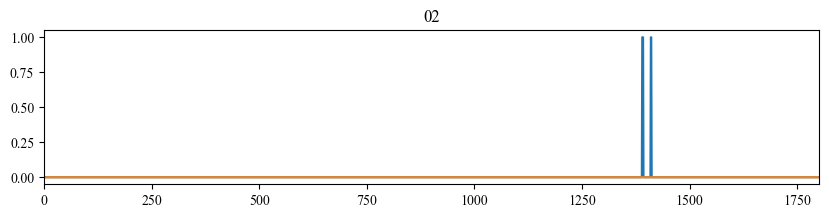

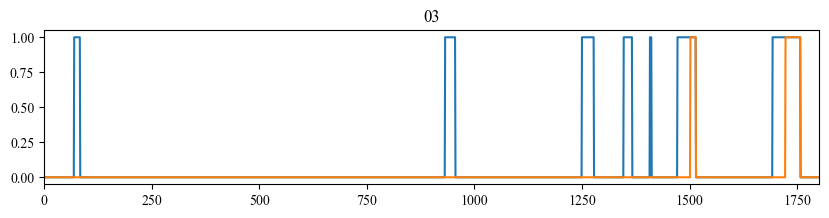

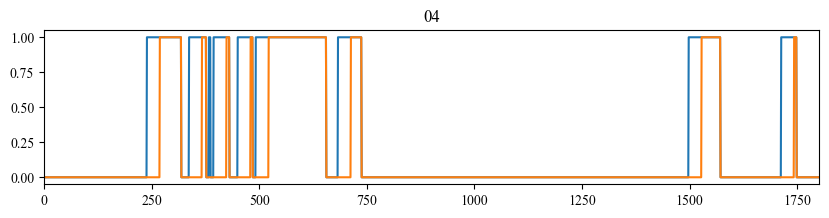

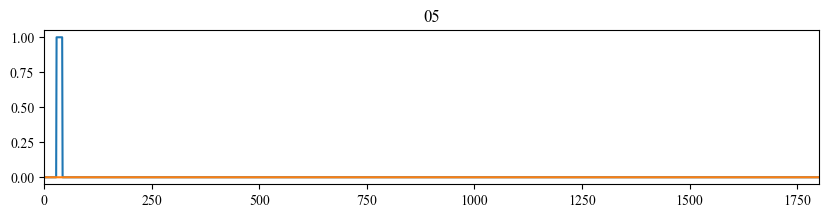

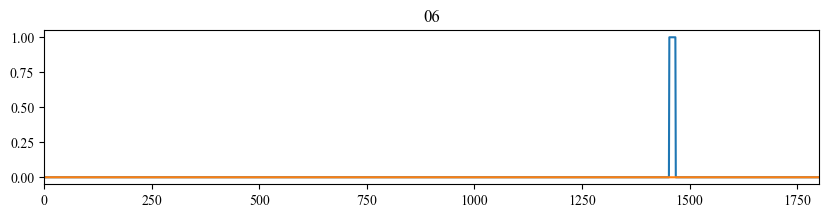

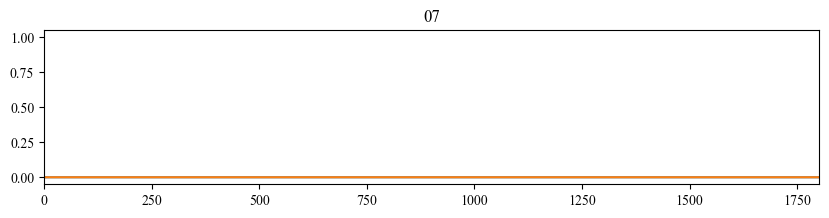

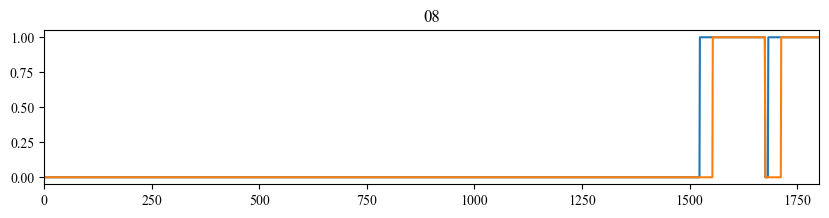

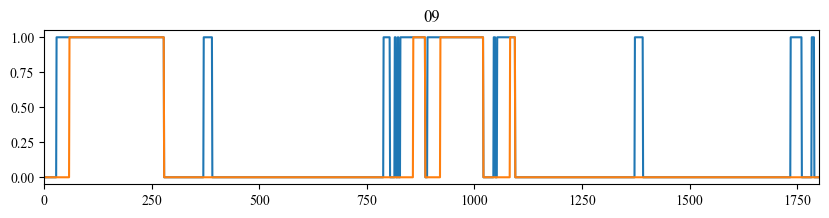

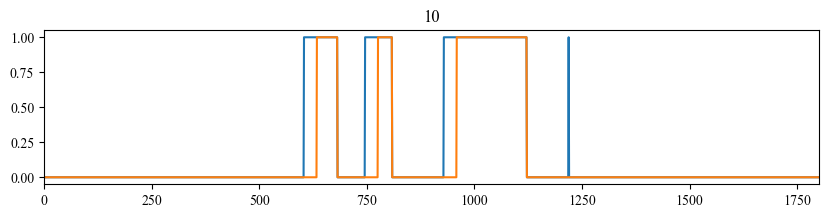

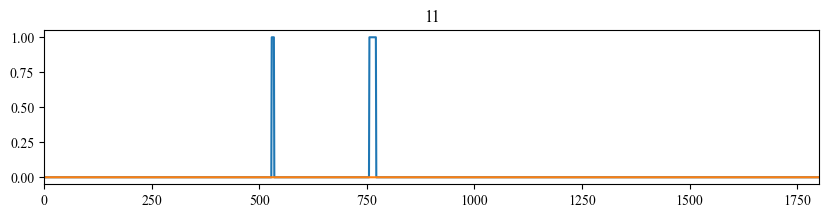

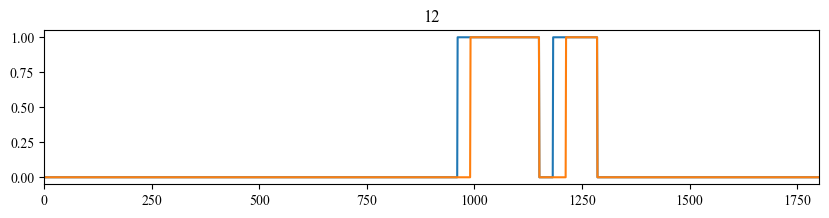

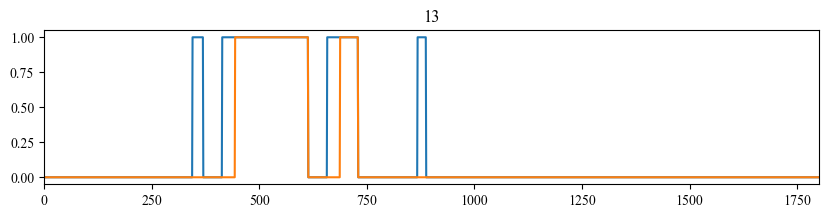

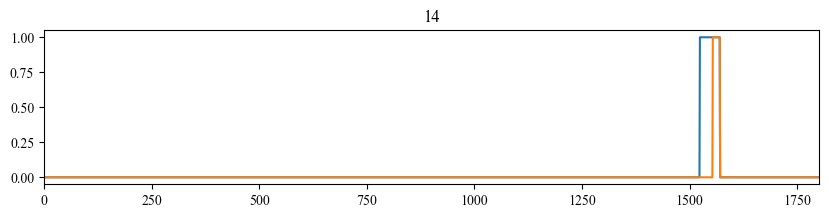

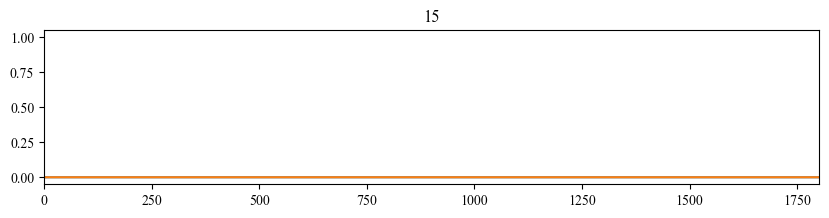

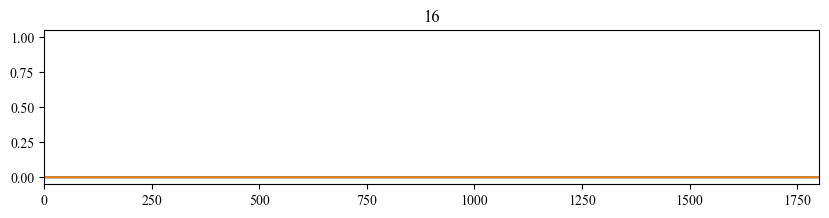

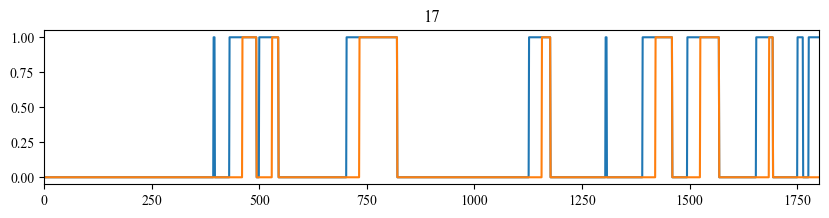

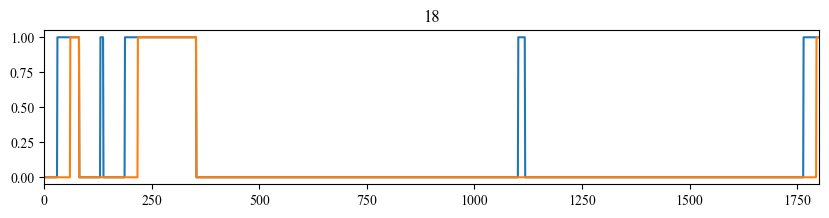

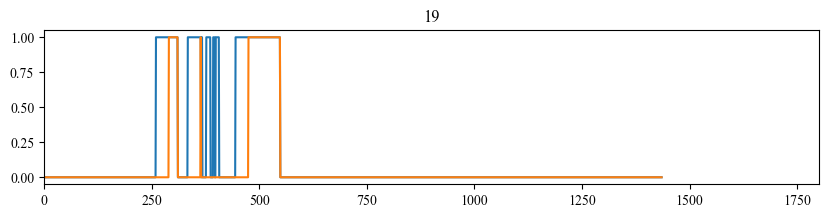

In [6]:
event_flags_all = {}
for video_num, vals in label_counts_all.items():
    vals_tmp = vals.T[3].copy()  # + vals.T[4]
    # vals_tmp /= vals.sum(axis=1)
    vals_tmp = moving_average(vals_tmp, 30)

    plt.figure(figsize=(10, 2))

    # plt.plot(vals_tmp)
    # plt.ylim(-0.05, 1.05)

    # diffs = np.diff(vals_tmp, 5)
    # plt.plot(diffs)
    # plt.ylim(-0.2, 0.2)

    vals_over_th = vals_tmp >= 3
    plt.plot(vals_over_th)

    duration_over_th = [0]
    pre_val = vals_over_th[0]
    duration = 0
    for val in vals_over_th[1:]:
        if pre_val == 1 and val == 1:
            duration += 1
            if duration >= 30:
                duration_over_th.append(1)
            else:
                duration_over_th.append(0)
        else:
            duration = 0
            duration_over_th.append(0)
        pre_val = val
    plt.plot(duration_over_th)
    plt.ylim(-0.05, 1.05)

    plt.xlim(0, 1801)
    plt.title(video_num)
    plt.show()

    event_flags_all[video_num] = {
        i * stride: flg for i, flg in enumerate(duration_over_th) if flg == 1
    }

In [7]:
def plot_mse(
    mse_x_dict,
    frame_count,
    stride,
    th,
    ylabel,
    mv_size=30,
    figpath=None,
    is_show=False,
    ylim=(0, 1),
):
    vals_dict = {}
    for _id, mse_dict in mse_x_dict.items():
        if len(mse_dict) < 1:
            continue
        n_frames = np.array(list(mse_dict.keys()))
        mses = np.array(list(mse_dict.values()))

        idxs = n_frames // stride
        n_samples = frame_count // stride + 1
        vals = np.full((n_samples,), np.nan, np.float32)
        vals[idxs] = mses

        vals = np.nan_to_num(vals, nan=0.0)

        # moving average
        vals = moving_average(vals, mv_size)
        vals_dict[_id] = vals.astype(np.float32)

    ids = list(vals_dict.keys())
    vals = np.array(list(vals_dict.values())).T
    vals = vals.astype(np.float32)

    mse_count = np.count_nonzero(vals >= th, axis=1)
    th_num_inds = 3
    over_th = mse_count >= th_num_inds

    duration_over_th = [0]
    pre_val = over_th[0]
    duration = 0
    for val in over_th[1:]:
        if pre_val == 1 and val == 1:
            duration += 1
            if duration >= 30:
                duration_over_th.append(1)
            else:
                duration_over_th.append(0)
        else:
            duration = 0
            duration_over_th.append(0)
        pre_val = val

    fig = plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.plot(vals, color="black", linewidth=1, alpha=0.3, label=ids)
    ax1.set_xlim(0, n_samples)
    ax1.set_xticks(np.arange(0, 1801, 60 * 3), np.arange(0, 1801, 60 * 3) // 60)
    ax1.set_xlabel("Minutes")
    margin = abs(ylim[1] - ylim[0]) * 0.05
    ax1.set_ylim(ylim[0] - margin, ylim[1] + margin)
    ylabels = np.linspace(ylim[0], ylim[1], 6)
    ax1.set_yticks(ylabels)
    ax1.set_ylabel(ylabel)

    ax2 = ax1.twinx()
    ax2.plot(duration_over_th, color="red", linewidth=1, label="mean")
    ax2.set_ylim(-1 * 0.05, 1 * 1.05)
    # ax2.set_ylabel(f"Count (MSE >= {th})")

    if figpath is not None:
        plt.savefig(figpath, bbox_inches="tight", dpi=300)
    if is_show:
        plt.show()
    plt.close()

01


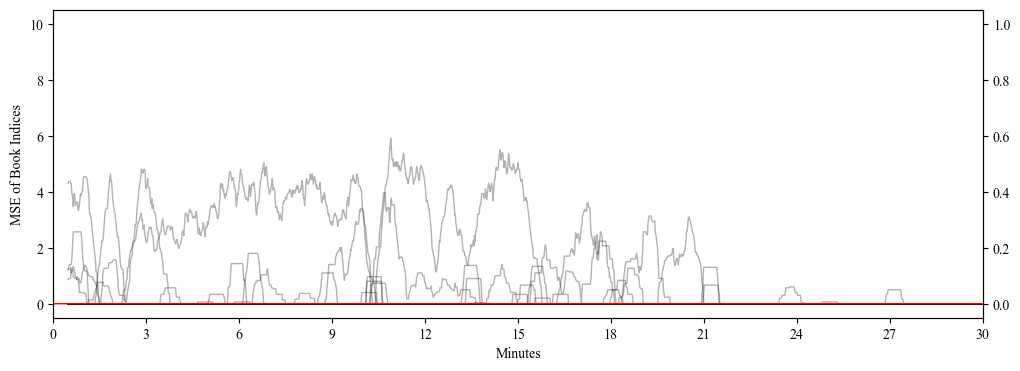

02


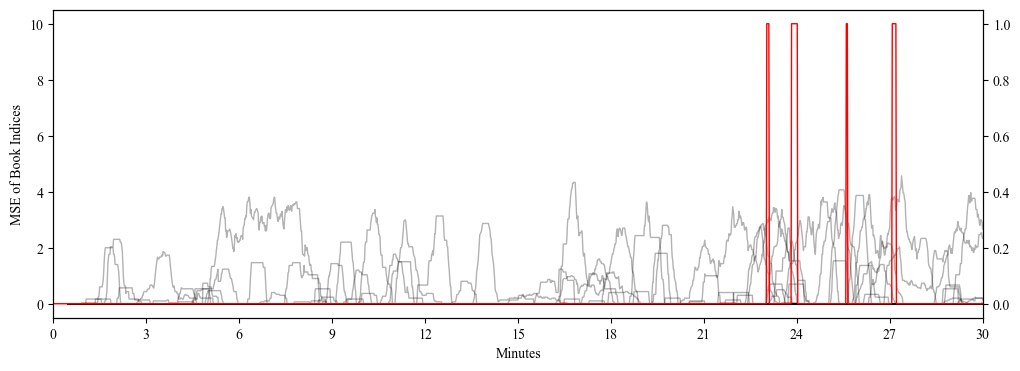

03


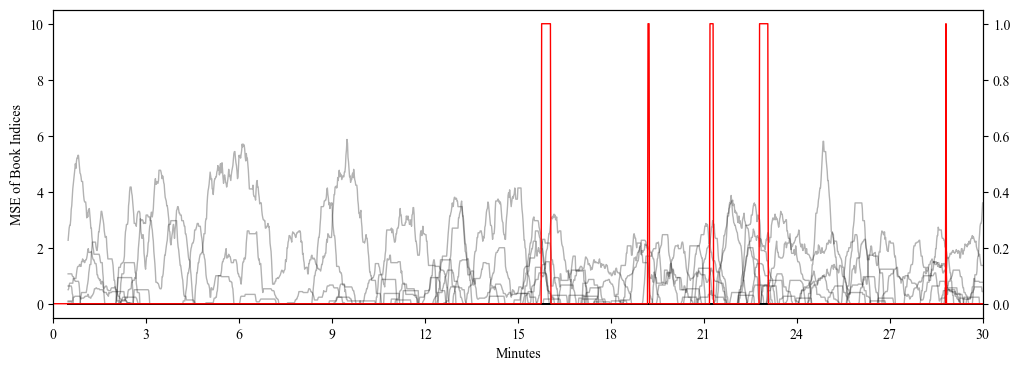

04


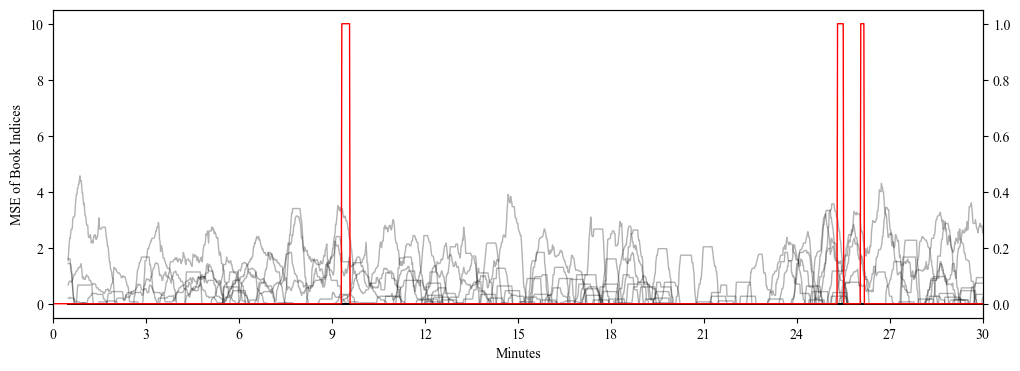

05


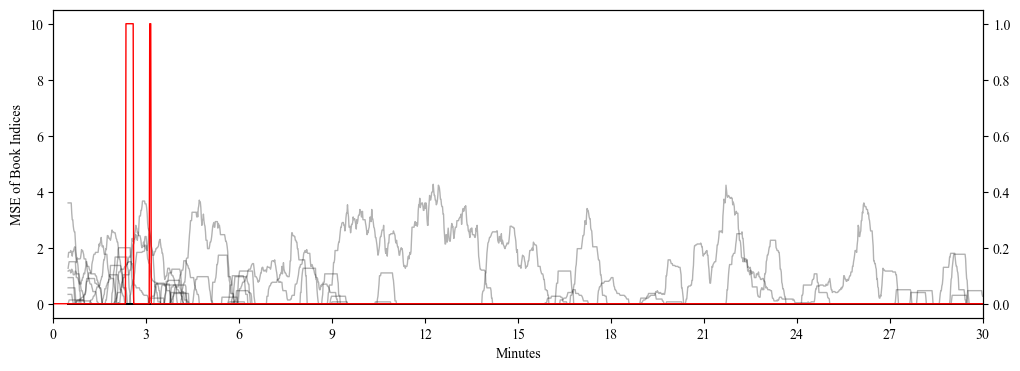

06


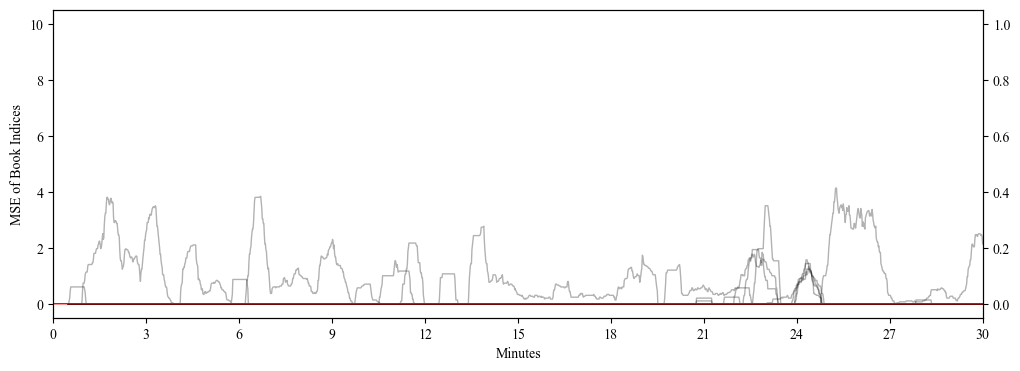

07


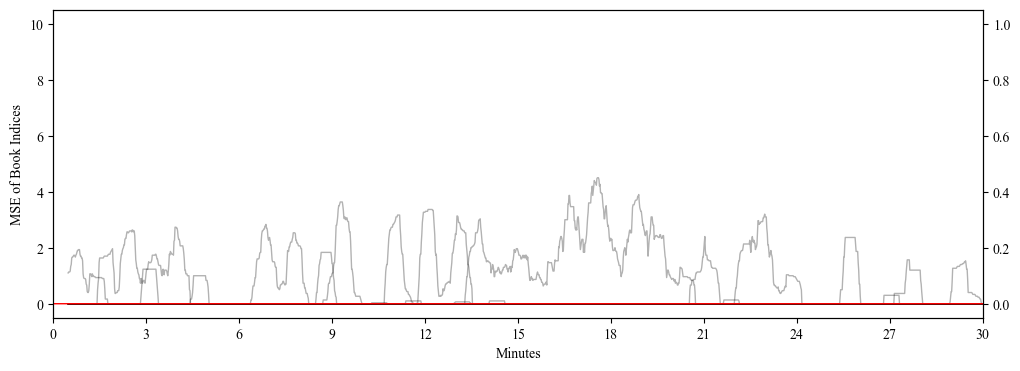

08


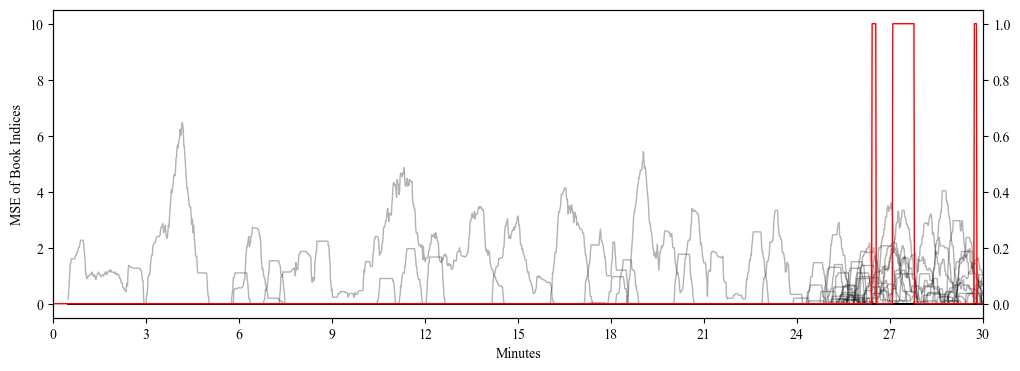

09


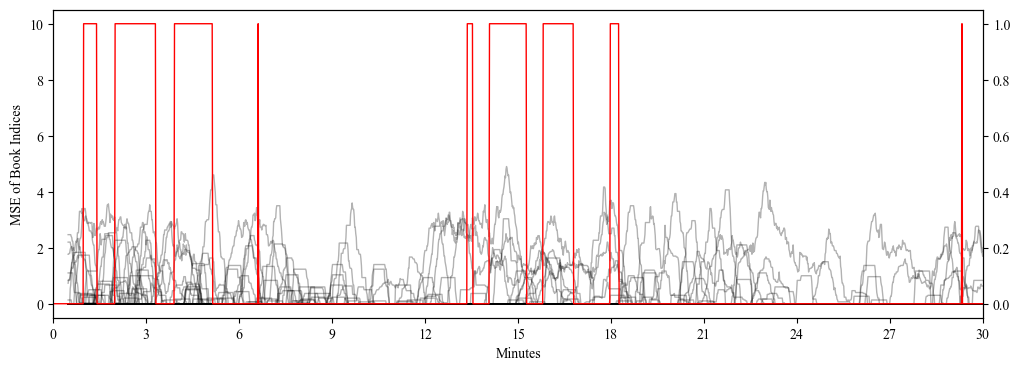

10


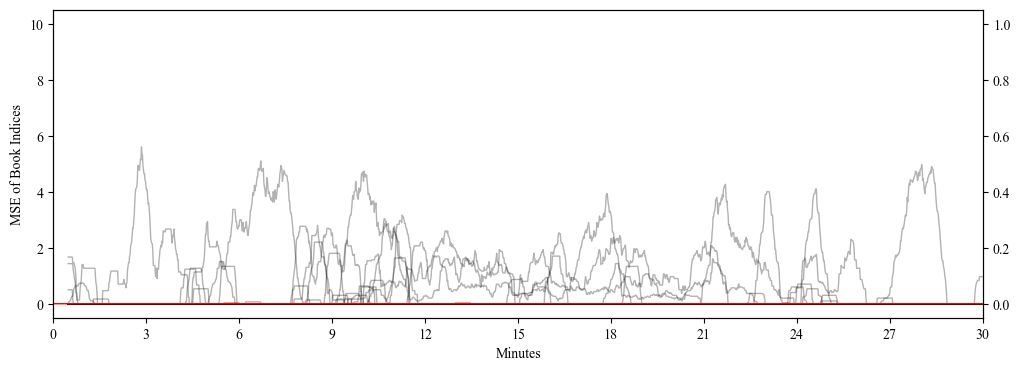

11


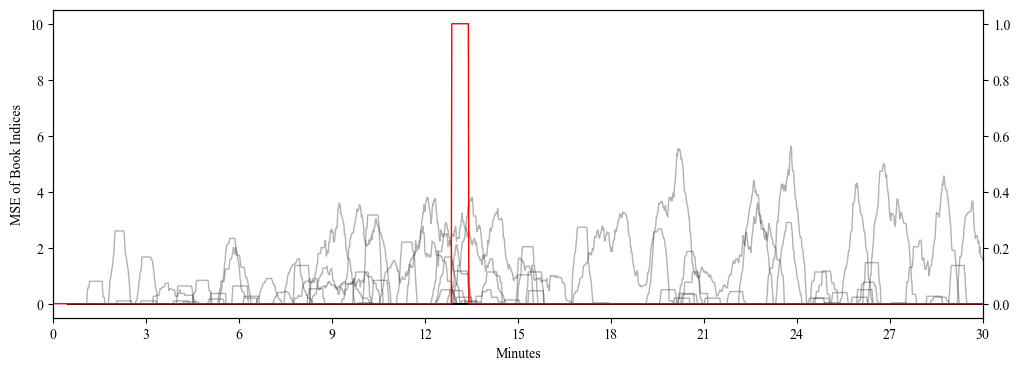

12


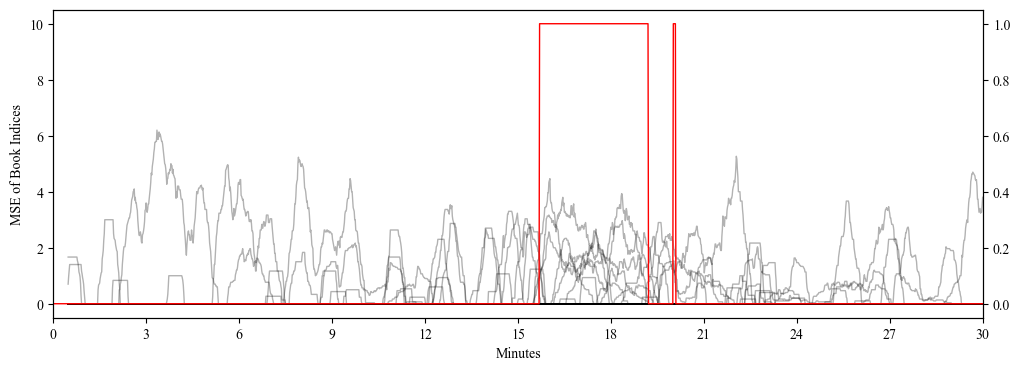

13


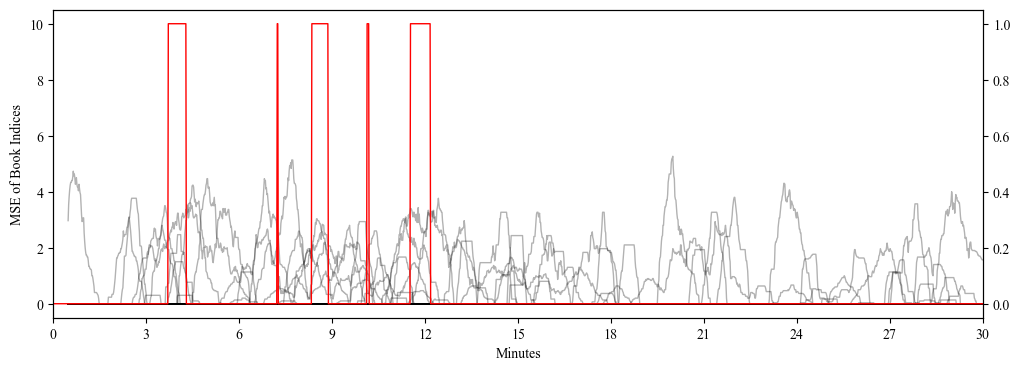

14


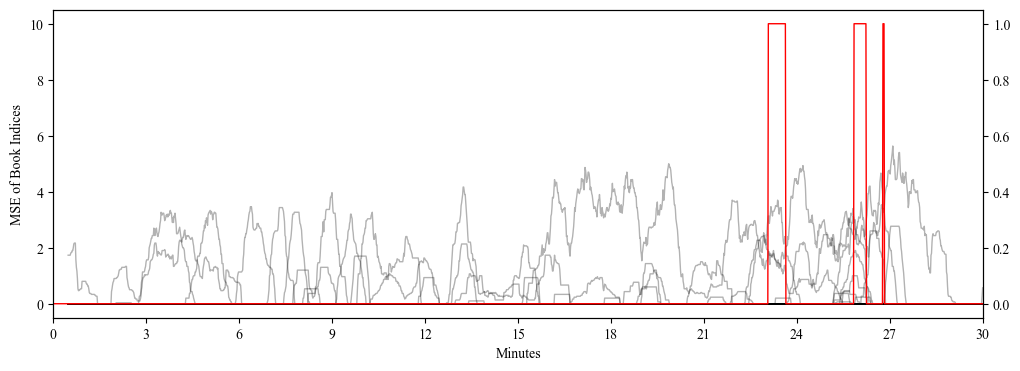

15


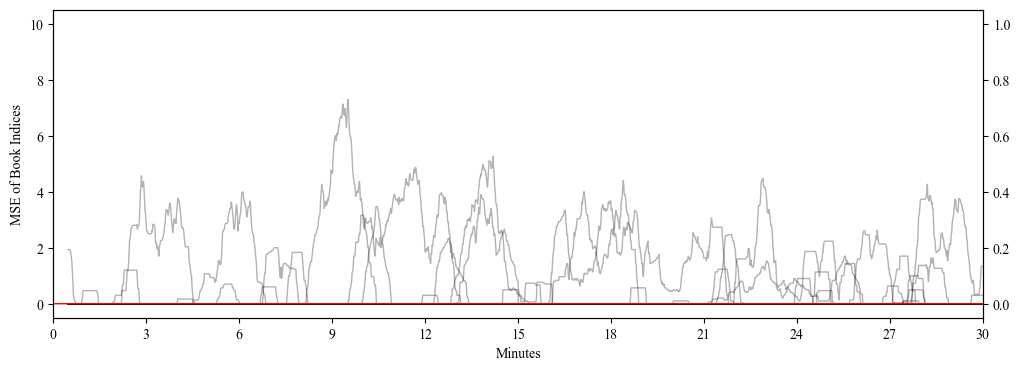

16


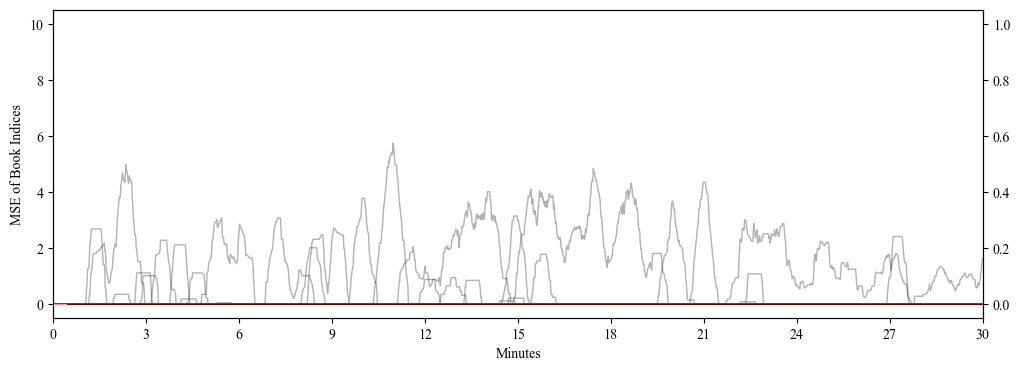

17


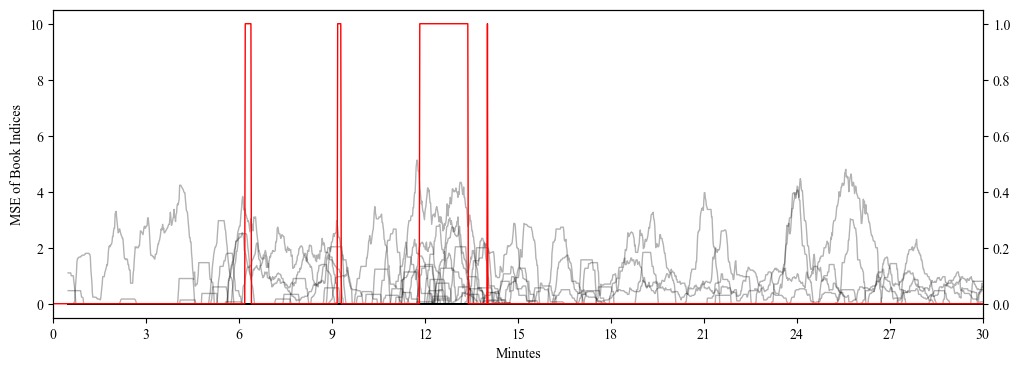

18


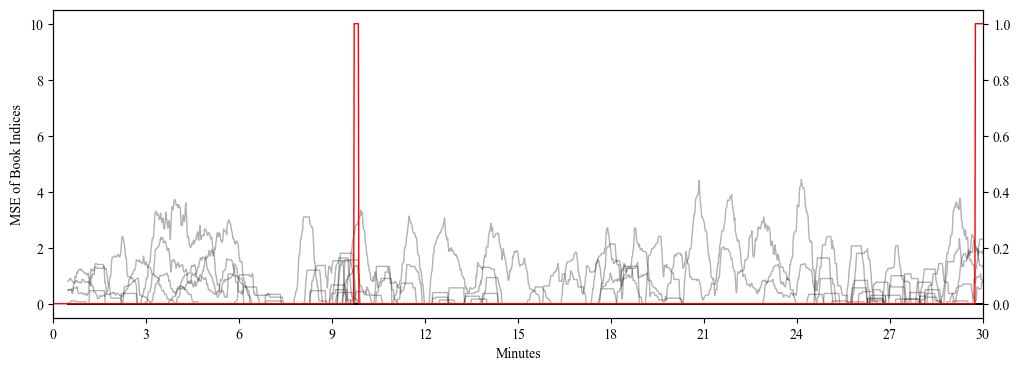

19


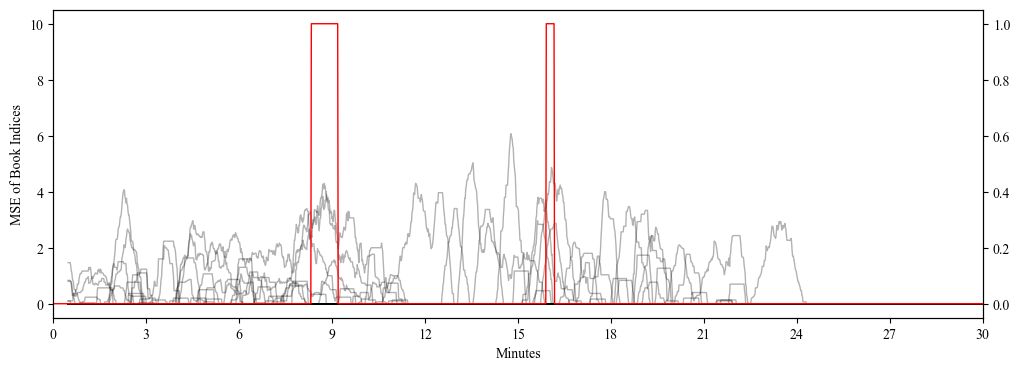

In [8]:
for video_num, results in results_all.items():
    print(video_num)
    pre_bi_dict = {}
    mse_bi_dict = {}
    for result in results:
        _, n_frame, _id = result["key"].split("_")
        n_frame = int(n_frame)
        _id = int(_id)
        bi = result["book_idx"]
        label = result["label"]
        if label != 3:
            continue

        if _id not in mse_bi_dict:
            pre_bi_dict[_id] = (n_frame, bi)
            mse_bi_dict[_id] = {}

        pre_nf, pre_bi = pre_bi_dict[_id]
        if pre_nf + stride == n_frame:
            # pre_bi_one_hot = np.eye(config.book_size)[pre_bi]
            # bi_one_hot = np.eye(config.book_size)[book_indices]
            mse = np.count_nonzero(pre_bi != bi)
            # mse = np.sum((pre_bi - bi) ** 2)
            mse_bi_dict[_id][n_frame] = mse
        pre_bi_dict[_id] = (n_frame, bi)

    plot_mse(mse_bi_dict, 54000, stride, 1, "MSE of Book Indices", is_show=True, ylim=(0, 10))